In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

In [2]:
path_csv = "./ESC-50-master/meta/esc50.csv"

In [3]:
df = pd.read_csv(path_csv)

In [4]:
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [5]:
category = ["crying_baby", "sneezing", "clapping", "breathing", "coughing", "footsteps", "laughing", "brushing_teeth", "snoring", "drinking_sipping"]

In [6]:
df = df.loc[df["category"].isin(category)]

In [7]:
df = df.reset_index(drop=True)

In [34]:
sample_num = 1
sr = 44100
max_size = 480
hop_length = 512
n_fft = 255
h = 128
n_mfcc = 128
epoch = 30
n_batch = 10

In [9]:
s = df.loc[sample_num,['filename']].values[0]
filename= f"./ESC-50-master/audio/{s}"
print(filename)

./ESC-50-master/audio/1-104089-B-22.wav


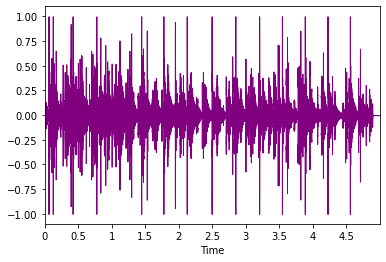

In [10]:
y, sr = librosa.load(filename, sr=sr)
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple',offset=0.0)

In [11]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [12]:
def generate_features(y_cut):
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length = hop_length)), h, max_size)
    MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length = hop_length,n_mfcc=n_mfcc),h,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    #repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image, padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [13]:
result = generate_features(y)

In [14]:
result.shape

(128, 480, 3)

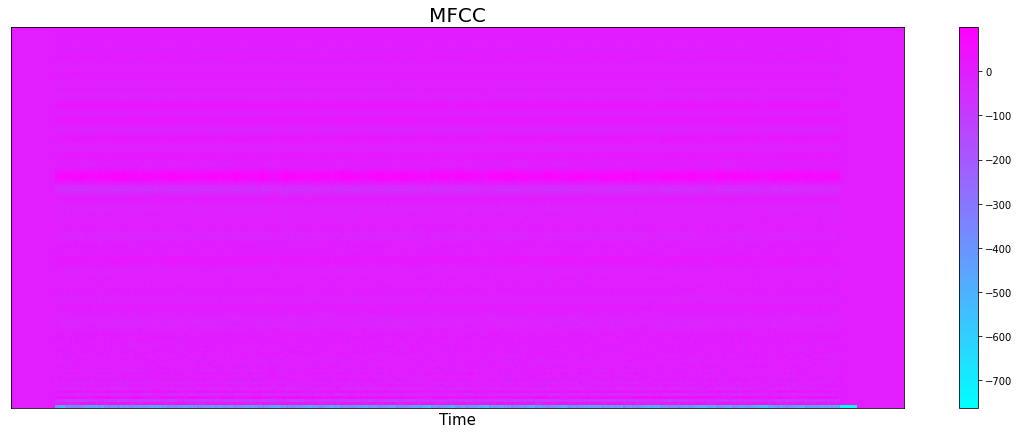

In [15]:
MFCCs = padding(librosa.feature.mfcc(y, n_fft=n_fft, hop_length=hop_length,n_mfcc=n_mfcc),h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

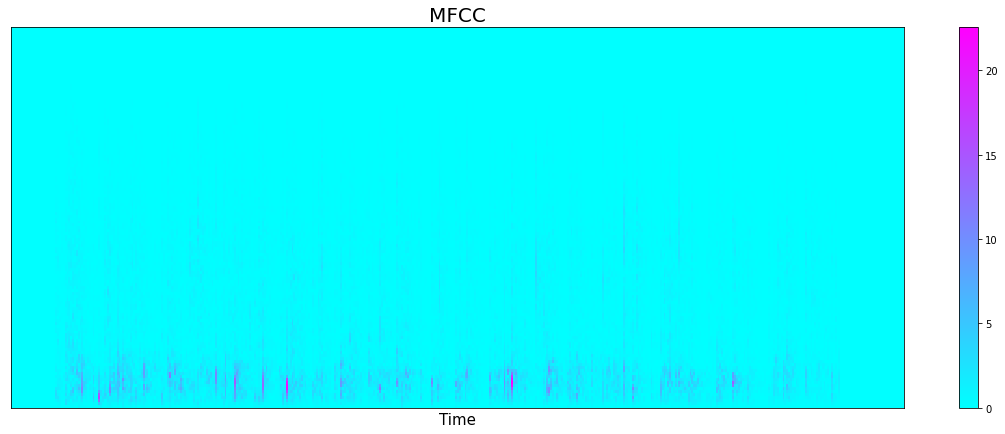

In [16]:
stft = padding(np.abs(librosa.stft(y, n_fft=n_fft, hop_length = hop_length)), h,max_size)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

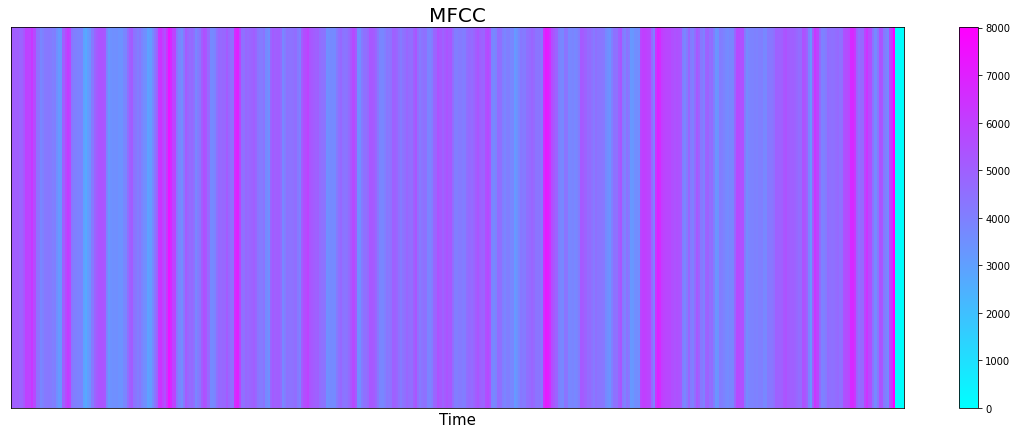

In [17]:
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_centroid,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

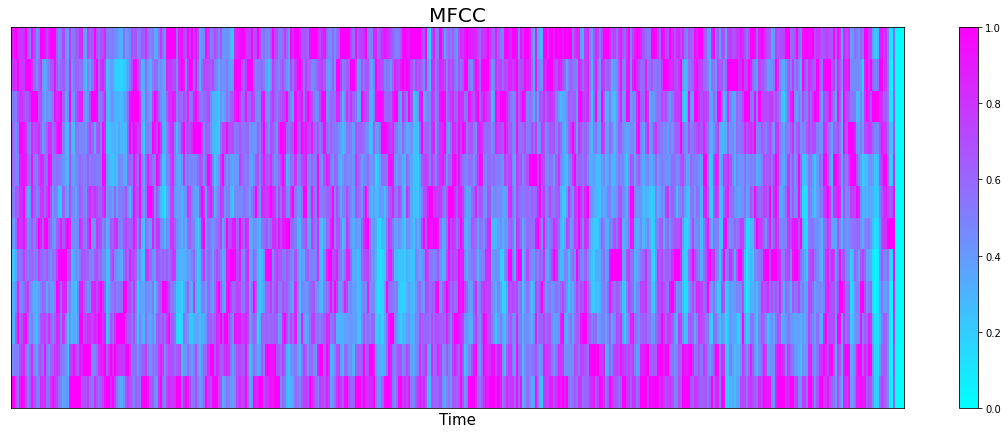

In [18]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(chroma_stft,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

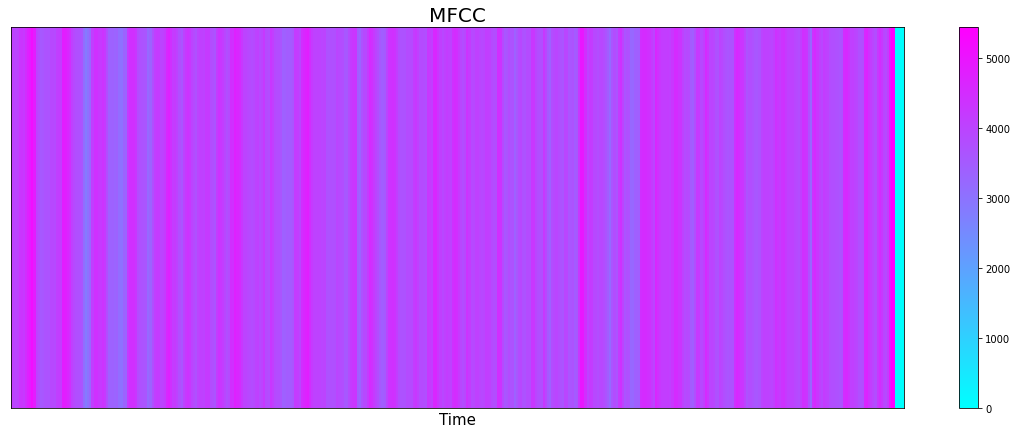

In [19]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(spec_bw,sr=sr, cmap='cool')
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [20]:
def get_features(df_in, rs=None):   
    features=[]
    labels = []
    
    for index, row in df_in.iterrows():
        label = df.loc[index,['category']].values[0]
        s = df.loc[index,['filename']].values[0]
        filename = f"./ESC-50-master/audio/{s}" 
        y, sr = librosa.load(filename,sr=44100)
        data = generate_features(y)
        if not rs is None:
            data = resize(data, rs)
        features.append(data[np.newaxis,...])    
        labels.append(label)     
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)

In [21]:
X, y = get_features(df, rs=(224,224))

In [22]:
enc = LabelEncoder()
enc.fit(y)
y = enc.transform(y)
n_classes = len(enc.classes_)

In [23]:
X.shape

(400, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


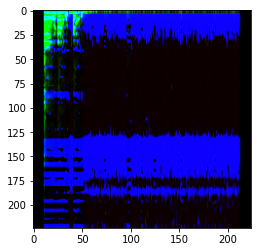

In [24]:
plt.imshow(X[144])

In [25]:
#Split twice to get the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((225, 224, 224, 3), (100, 224, 224, 3), (75, 224, 224, 3), 225, 100, 75)

In [26]:
X_train = np.array((X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train)))
X_test = np.array((X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test)))
X_val = np.array((X_val-np.min(X_val))/(np.max(X_val)-np.min(X_val)))
X_train = X_train/np.std(X_train)
X_test = X_test/np.std(X_test)
X_val = X_val/np.std(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [86]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [87]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [88]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 165ms/step - loss: 100.3574 - accuracy: 0.1144 - val_loss: 3333273907960480213762048.0000 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 3s 128ms/step - loss: 4.7224 - accuracy: 0.0996 - val_loss: 3388775367442432.0000 - val_accuracy: 0.0933
Epoch 3/30
23/23 [==============================] - 3s 128ms/step - loss: 3.0447 - accuracy: 0.0953 - val_loss: 352271597568.0000 - val_accuracy: 0.0933
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 3.1950 - accuracy: 0.1054 - val_loss: 2185346304.0000 - val_accuracy: 0.0933
Epoch 5/30
23/23 [==============================] - 3s 127ms/step - loss: 3.2980 - accuracy: 0.0538 - val_loss: 82857000.0000 - val_accuracy: 0.0933
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 2.6449 - accuracy: 0.1160 - val_loss: 6892515.0000 - val_accuracy: 0.0933
Epoch 7/30
23/23 [==============================] - 3s 127ms/step - loss: 

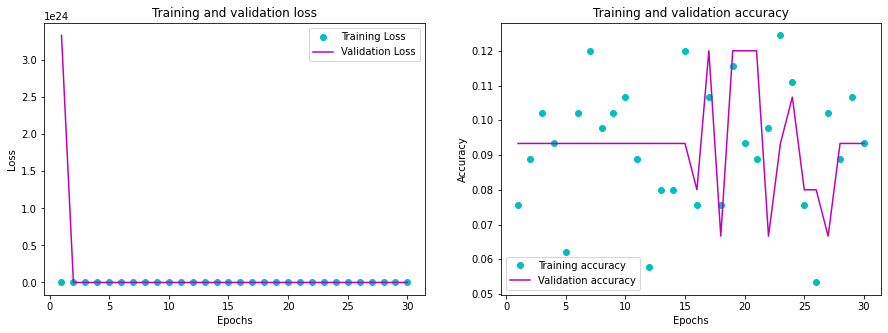

In [89]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [92]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 59ms/step - loss: 2.3487 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]], shape=(10, 10), dtype=int32)


# Intento 2 

In [93]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [94]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [95]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 161ms/step - loss: 3.6479 - accuracy: 0.1632 - val_loss: 23031.5879 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 126ms/step - loss: 2.4999 - accuracy: 0.2086 - val_loss: 23.4515 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 126ms/step - loss: 1.9855 - accuracy: 0.2817 - val_loss: 2.3055 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 2.0117 - accuracy: 0.3290 - val_loss: 2.7307 - val_accuracy: 0.1333
Epoch 5/30
23/23 [==============================] - 3s 126ms/step - loss: 1.5215 - accuracy: 0.4453 - val_loss: 11.4483 - val_accuracy: 0.0533
Epoch 6/30
23/23 [==============================] - 3s 126ms/step - loss: 1.5983 - accuracy: 0.4360 - val_loss: 2.2986 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 3s 126ms/step - loss: 1.5029 - accuracy: 0.4801 - val_loss: 2.3012 - val_accuracy: 0.1067


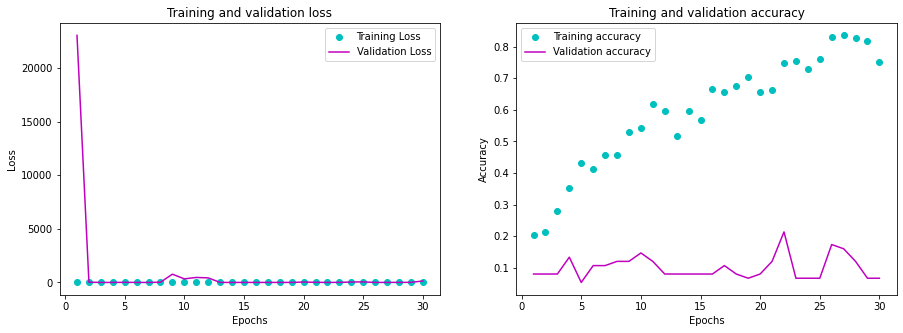

In [96]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [97]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 59ms/step - loss: 123.7680 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


# Intento 3 

In [98]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [99]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [100]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 163ms/step - loss: 2.0017 - accuracy: 0.3157 - val_loss: 2.7438 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 126ms/step - loss: 0.9598 - accuracy: 0.6678 - val_loss: 2.6134 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 127ms/step - loss: 0.5889 - accuracy: 0.7769 - val_loss: 2.7959 - val_accuracy: 0.0133
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 0.6454 - accuracy: 0.8037 - val_loss: 3.1773 - val_accuracy: 0.0667
Epoch 5/30
23/23 [==============================] - 3s 126ms/step - loss: 0.4374 - accuracy: 0.8430 - val_loss: 3.4556 - val_accuracy: 0.0667
Epoch 6/30
23/23 [==============================] - 3s 126ms/step - loss: 0.2494 - accuracy: 0.9307 - val_loss: 3.3532 - val_accuracy: 0.0667
Epoch 7/30
23/23 [==============================] - 3s 127ms/step - loss: 0.2103 - accuracy: 0.9244 - val_loss: 3.6315 - val_accuracy: 0.1467
Epoch 

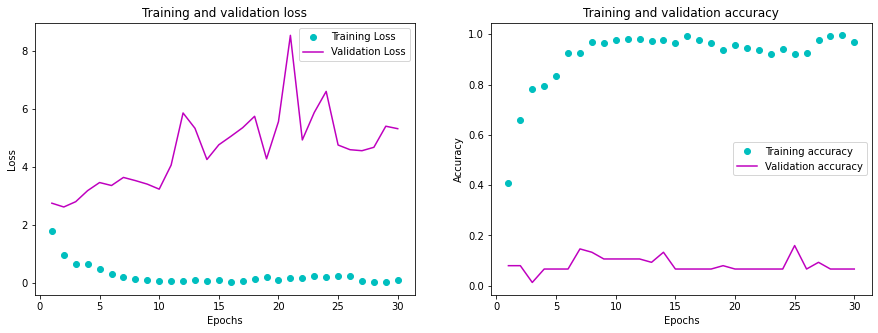

In [101]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [102]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 59ms/step - loss: 5.8599 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


# cambio de SGD

In [103]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [104]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [105]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 159ms/step - loss: 8.6483 - accuracy: 0.0929 - val_loss: 2339217.5000 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 122ms/step - loss: 2.3296 - accuracy: 0.1654 - val_loss: 12012.8662 - val_accuracy: 0.0933
Epoch 3/30
23/23 [==============================] - 3s 124ms/step - loss: 2.2752 - accuracy: 0.1505 - val_loss: 82.2670 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 3s 122ms/step - loss: 2.2519 - accuracy: 0.1741 - val_loss: 2.2931 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 3s 123ms/step - loss: 2.1650 - accuracy: 0.2134 - val_loss: 3.4616 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 123ms/step - loss: 2.0257 - accuracy: 0.2392 - val_loss: 2.3218 - val_accuracy: 0.0933
Epoch 7/30
23/23 [==============================] - 3s 123ms/step - loss: 1.9806 - accuracy: 0.2776 - val_loss: 2.3383 - val_accuracy: 0.

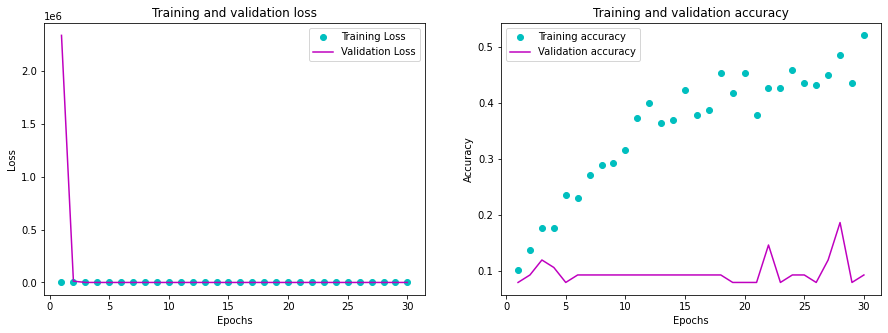

In [106]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [107]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 59ms/step - loss: 2.3050 - accuracy: 0.1600
Confusion_matrix:  tf.Tensor(
[[0 0 0 5 2 0 0 0 0 3]
 [0 0 0 3 1 0 1 0 0 5]
 [0 0 0 1 9 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 6]
 [0 0 0 7 3 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 8]
 [0 0 0 5 0 0 0 0 0 5]
 [0 0 0 4 4 0 0 0 0 2]
 [0 0 0 2 0 0 0 0 0 8]
 [0 0 0 1 0 0 0 0 0 9]], shape=(10, 10), dtype=int32)


# INTENTO 1

In [108]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [109]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [110]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 158ms/step - loss: 2.5691 - accuracy: 0.2226 - val_loss: 3.2247 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 122ms/step - loss: 2.3103 - accuracy: 0.3168 - val_loss: 3.5755 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 122ms/step - loss: 1.5535 - accuracy: 0.4796 - val_loss: 3.4834 - val_accuracy: 0.0533
Epoch 4/30
23/23 [==============================] - 3s 122ms/step - loss: 1.0400 - accuracy: 0.6263 - val_loss: 3.5430 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 123ms/step - loss: 1.0595 - accuracy: 0.6302 - val_loss: 3.3656 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 122ms/step - loss: 0.5679 - accuracy: 0.8112 - val_loss: 3.4845 - val_accuracy: 0.1467
Epoch 7/30
23/23 [==============================] - 3s 122ms/step - loss: 0.3783 - accuracy: 0.8816 - val_loss: 4.1158 - val_accuracy: 0.1067
Epoch 

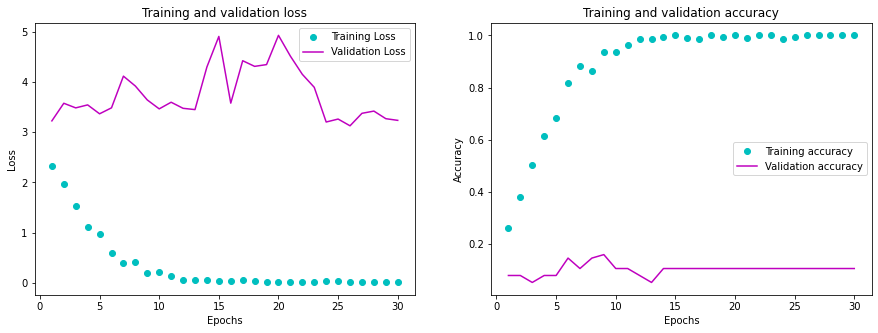

In [111]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [112]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 3.6583 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0 10  0]], shape=(10, 10), dtype=int32)


# INTENTO 2

In [113]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [114]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [115]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 157ms/step - loss: 2.3027 - accuracy: 0.1589 - val_loss: 2.4310 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 3s 122ms/step - loss: 1.5905 - accuracy: 0.4924 - val_loss: 2.7545 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 122ms/step - loss: 1.1994 - accuracy: 0.6852 - val_loss: 2.9029 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 123ms/step - loss: 1.0030 - accuracy: 0.7732 - val_loss: 3.2978 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 122ms/step - loss: 0.7001 - accuracy: 0.8797 - val_loss: 3.6507 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 122ms/step - loss: 0.6169 - accuracy: 0.8921 - val_loss: 3.8342 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 122ms/step - loss: 0.6218 - accuracy: 0.8888 - val_loss: 3.4358 - val_accuracy: 0.0800
Epoch 

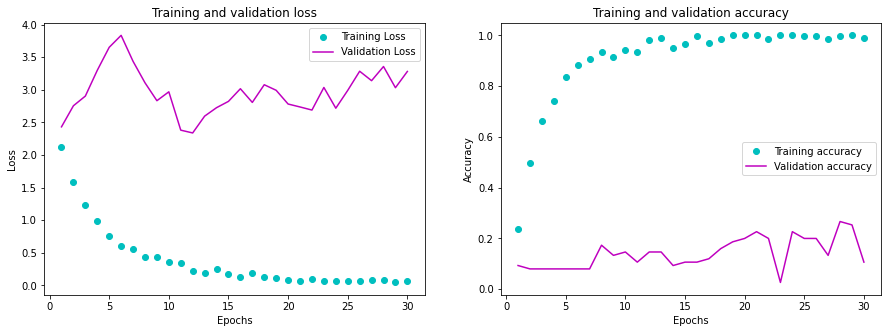

In [116]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [117]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 2.7123 - accuracy: 0.2000
Confusion_matrix:  tf.Tensor(
[[0 0 1 0 0 0 0 1 4 4]
 [0 4 3 0 0 0 0 0 1 2]
 [0 1 2 0 0 0 0 0 7 0]
 [0 1 0 0 0 0 0 0 4 5]
 [0 0 2 0 0 0 0 0 4 4]
 [0 1 1 0 0 0 0 0 5 3]
 [0 0 3 0 0 0 0 0 7 0]
 [0 0 1 0 0 0 0 2 4 3]
 [0 0 0 0 0 0 0 0 9 1]
 [0 1 1 0 0 0 0 0 5 3]], shape=(10, 10), dtype=int32)


# INTENTO 3

In [118]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [119]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [120]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 157ms/step - loss: 2.3975 - accuracy: 0.1078 - val_loss: 2.8393 - val_accuracy: 0.1200
Epoch 2/30
23/23 [==============================] - 3s 123ms/step - loss: 2.1079 - accuracy: 0.2260 - val_loss: 2.8327 - val_accuracy: 0.1200
Epoch 3/30
23/23 [==============================] - 3s 122ms/step - loss: 1.8993 - accuracy: 0.3368 - val_loss: 2.9110 - val_accuracy: 0.1200
Epoch 4/30
23/23 [==============================] - 3s 122ms/step - loss: 1.6932 - accuracy: 0.4781 - val_loss: 3.5361 - val_accuracy: 0.1200
Epoch 5/30
23/23 [==============================] - 3s 121ms/step - loss: 1.5908 - accuracy: 0.5453 - val_loss: 3.5737 - val_accuracy: 0.1200
Epoch 6/30
23/23 [==============================] - 3s 122ms/step - loss: 1.5710 - accuracy: 0.4909 - val_loss: 3.5353 - val_accuracy: 0.1200
Epoch 7/30
23/23 [==============================] - 3s 124ms/step - loss: 1.4053 - accuracy: 0.6682 - val_loss: 3.1184 - val_accuracy: 0.1467
Epoch 

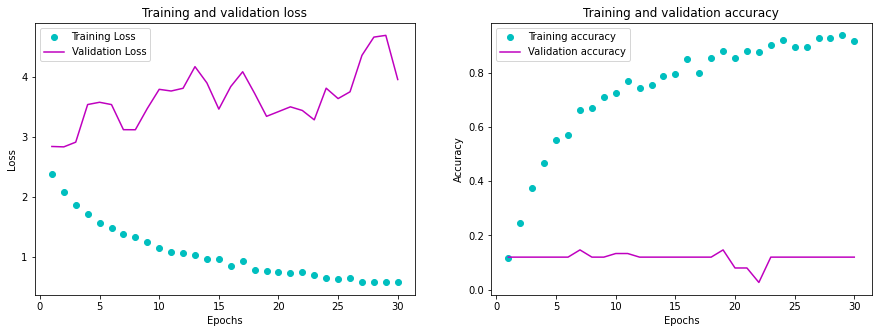

In [121]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [122]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 4.7785 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


# INTENTO 4

In [123]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [124]:
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [125]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 7s 156ms/step - loss: 2.7598 - accuracy: 0.0864 - val_loss: 2.6427 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 3s 122ms/step - loss: 2.5492 - accuracy: 0.1701 - val_loss: 2.6150 - val_accuracy: 0.1067
Epoch 3/30
23/23 [==============================] - 3s 122ms/step - loss: 2.6313 - accuracy: 0.1362 - val_loss: 2.8326 - val_accuracy: 0.1067
Epoch 4/30
23/23 [==============================] - 3s 123ms/step - loss: 2.4096 - accuracy: 0.1356 - val_loss: 2.9668 - val_accuracy: 0.1067
Epoch 5/30
23/23 [==============================] - 3s 122ms/step - loss: 2.3761 - accuracy: 0.1994 - val_loss: 3.3531 - val_accuracy: 0.1067
Epoch 6/30
23/23 [==============================] - 3s 122ms/step - loss: 2.4693 - accuracy: 0.2053 - val_loss: 3.7250 - val_accuracy: 0.1067
Epoch 7/30
23/23 [==============================] - 3s 123ms/step - loss: 2.4092 - accuracy: 0.1639 - val_loss: 3.9774 - val_accuracy: 0.1200
Epoch 

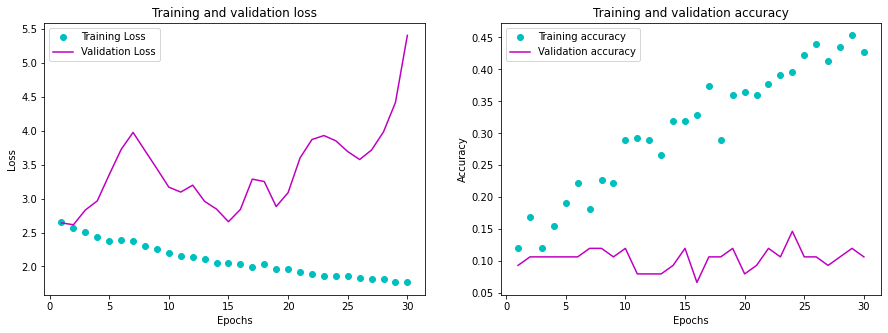

In [126]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [127]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 61ms/step - loss: 3.9940 - accuracy: 0.0900
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  9  0  1  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  6  0  4  0  0  0]
 [ 1  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  5  0  5  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  8  0  2  0  0  0]
 [ 0  0  0  0  1  0  9  0  0  0]
 [ 0  0  0  0  9  0  1  0  0  0]], shape=(10, 10), dtype=int32)


# Cambio a Adamax

In [128]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [129]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.1)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [130]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 161ms/step - loss: 91.0377 - accuracy: 0.1360 - val_loss: 6294850853819908096.0000 - val_accuracy: 0.0800
Epoch 2/30
23/23 [==============================] - 3s 127ms/step - loss: 3.2758 - accuracy: 0.1183 - val_loss: 95410380800.0000 - val_accuracy: 0.0800
Epoch 3/30
23/23 [==============================] - 3s 127ms/step - loss: 2.7694 - accuracy: 0.1609 - val_loss: 56635988.0000 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 2.5237 - accuracy: 0.1546 - val_loss: 983600.8750 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 127ms/step - loss: 2.2391 - accuracy: 0.1840 - val_loss: 114950.9062 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 2.1852 - accuracy: 0.2287 - val_loss: 30683.0664 - val_accuracy: 0.0800
Epoch 7/30
23/23 [==============================] - 3s 127ms/step - loss: 2.3257 - accuracy: 0.117

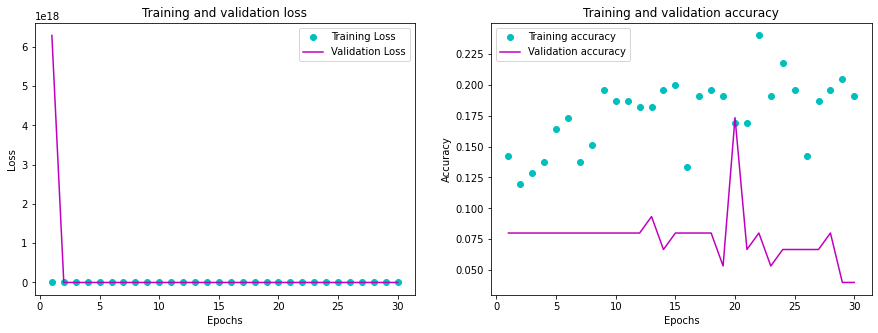

In [131]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [132]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 60ms/step - loss: 5.3795 - accuracy: 0.0300
Confusion_matrix:  tf.Tensor(
[[ 2  0  8  0  0  0  0  0  0  0]
 [ 8  0  2  0  0  0  0  0  0  0]
 [ 9  0  1  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 9  0  1  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 3  0  7  0  0  0  0  0  0  0]
 [ 2  0  8  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]], shape=(10, 10), dtype=int32)


# intnto 2

In [133]:
baseModel = ResNet50(weights='imagenet',include_top=False)
x = baseModel.output
x = Dense(128)(x)
x = GlobalAveragePooling2D()(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=baseModel.input, outputs=predictions)
model.save("base-resnet1.h5")

In [134]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.00001)
model.compile(optimizer=opt ,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [135]:
history = model.fit(X_train, y_train, epochs=epoch, batch_size=n_batch, validation_data= (X_val, y_val))

Epoch 1/30
23/23 [==============================] - 8s 162ms/step - loss: 2.5732 - accuracy: 0.1354 - val_loss: 2.7749 - val_accuracy: 0.0933
Epoch 2/30
23/23 [==============================] - 3s 128ms/step - loss: 1.6750 - accuracy: 0.5107 - val_loss: 2.7499 - val_accuracy: 0.0667
Epoch 3/30
23/23 [==============================] - 3s 127ms/step - loss: 1.3342 - accuracy: 0.6595 - val_loss: 2.8014 - val_accuracy: 0.0800
Epoch 4/30
23/23 [==============================] - 3s 127ms/step - loss: 1.1009 - accuracy: 0.7559 - val_loss: 3.0584 - val_accuracy: 0.0800
Epoch 5/30
23/23 [==============================] - 3s 127ms/step - loss: 0.9697 - accuracy: 0.7649 - val_loss: 3.2040 - val_accuracy: 0.0800
Epoch 6/30
23/23 [==============================] - 3s 128ms/step - loss: 0.8267 - accuracy: 0.8792 - val_loss: 3.1214 - val_accuracy: 0.0133
Epoch 7/30
23/23 [==============================] - 3s 127ms/step - loss: 0.7276 - accuracy: 0.9060 - val_loss: 3.2425 - val_accuracy: 0.0000e+00
Ep

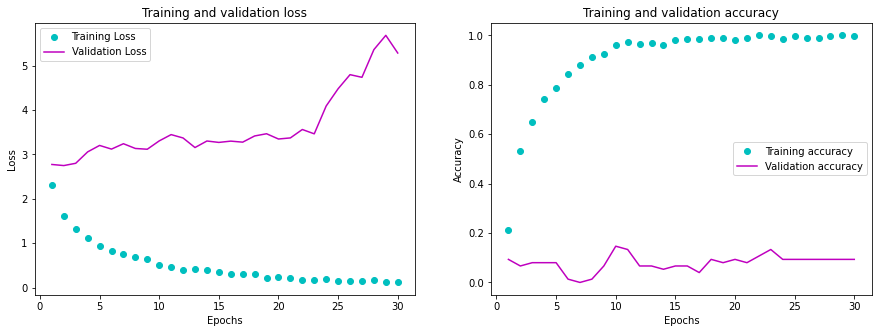

In [136]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,epoch+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [137]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

4/4 [==============================] - 0s 59ms/step - loss: 5.0536 - accuracy: 0.1000
Confusion_matrix:  tf.Tensor(
[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]], shape=(10, 10), dtype=int32)
